<a href="https://colab.research.google.com/github/rubycho/cv-notes/blob/master/04%20Computer%20Vision/Topic02.%20Pretrained%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Caution

- This file is using Google Colab to use GPU.
- If you have sufficient GPU on your laptop, then you can just change the `DATASET_DIR`, `NEW_DATASET_DIR` variable and run on local jupyter.
- If you don't have GPU, training will be **really slow**.
- If you use Colab, disk operation (with Google Drive) is **slow**.

## VGG-16 architecture

VGG16 is a model which is trained in dataset called "ImageNet", and classify images in 1000 categories. We will modify this model to only classify whether the image has a cat or a dog, re-training with a small dataset.

You can check out the layers of VGG-16 on below link.

[VGG-16 network (neurohive)](https://neurohive.io/en/popular-networks/vgg16/)

The abstract code on Keras would be like this:

```python
Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3))
Conv2D(64, (3, 3), padding='same', activation='relu')
MaxPooling2D((2, 2))
Conv2D(128, (3, 3), padding='same', activation='relu')
Conv2D(128, (3, 3), padding='same', activation='relu')
MaxPooling2D((2, 2))
Conv2D(256, (3, 3), padding='same', activation='relu')
Conv2D(256, (3, 3), padding='same', activation='relu')
Conv2D(256, (3, 3), padding='same', activation='relu')
MaxPooling2D((2, 2))
Conv2D(512, (3, 3), padding='same', activation='relu')
Conv2D(512, (3, 3), padding='same', activation='relu')
Conv2D(512, (3, 3), padding='same', activation='relu')
MaxPooling2D((2, 2))
Flatten()
Dense(4096, activation='relu')
Dense(4096, activation='relu')
Dense(1000, activation='softmax')
```

## Dataset Preparation

Download cats_vs_dogs dataset from Microsoft and place "PetImages" on drive "assets" directory.

https://www.microsoft.com/en-us/download/details.aspx?id=54765

You can just upload 500 images each, sustaining directory structure.

```
assets/
  PetImages/
    Cat/
      500 images
    Dog/
      500 images
```

In [ ]:
# no need to run on local machine

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


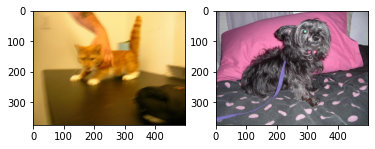

In [ ]:
"""
check image
"""

import os

from matplotlib import pyplot as plt
from matplotlib import image as mimage

DATASET_DIR = '/content/drive/My Drive/assets/PetImages/'
NEW_DATASET_DIR = '/content/PretrainedModel/'

cat = mimage.imread(os.path.join(DATASET_DIR, 'Cat/0.jpg'))
dog = mimage.imread(os.path.join(DATASET_DIR, 'Dog/0.jpg'))

fig = plt.figure()

fig.add_subplot(1, 2, 1)
plt.imshow(cat)

fig.add_subplot(1, 2, 2)
plt.imshow(dog)

plt.show(fig)

In [ ]:
"""
create trainset and testset
"""

import glob
import shutil

CAT_DIR = os.path.join(DATASET_DIR, 'Cat')
DOG_DIR = os.path.join(DATASET_DIR, 'Dog')

TRAIN_DIR = os.path.join(NEW_DATASET_DIR, 'train/')
TEST_DIR = os.path.join(NEW_DATASET_DIR, 'test/')

TRAIN_CAT_DIR = os.path.join(TRAIN_DIR, 'Cat/')
TRAIN_DOG_DIR = os.path.join(TRAIN_DIR, 'Dog/')

TEST_CAT_DIR = os.path.join(TEST_DIR, 'Cat/')
TEST_DOG_DIR = os.path.join(TEST_DIR, 'Dog/')

if os.path.exists(NEW_DATASET_DIR):
    raise Exception("dataset dir already exists!")
    
os.makedirs(TRAIN_CAT_DIR)
os.makedirs(TRAIN_DOG_DIR)
os.makedirs(TEST_CAT_DIR)
os.makedirs(TEST_DOG_DIR)

# use small dataset
len_cats = len(glob.glob(os.path.join(CAT_DIR, '*.jpg')))
len_dogs = len(glob.glob(os.path.join(DOG_DIR, '*.jpg')))

print("Found %d images of cats." % len_cats)
print("Found %d images of dogs." % len_cats)

print("Please wait, copy operation may take time...")

def copyfile(from_dir, to_dir, filename):
    shutil.copyfile(
        os.path.join(from_dir, filename),
        os.path.join(to_dir, filename)
    )

train_idx = len_cats // 4 * 3
for i in range(train_idx):
    copyfile(CAT_DIR, TRAIN_CAT_DIR, str(i) + '.jpg')
for i in range(train_idx, len_cats):
    copyfile(CAT_DIR, TEST_CAT_DIR, str(i) + '.jpg')

train_idx = len_dogs // 4 * 3
for i in range(train_idx):
    copyfile(DOG_DIR, TRAIN_DOG_DIR, str(i) + '.jpg')
for i in range(train_idx, len_dogs):
    copyfile(DOG_DIR, TEST_DOG_DIR, str(i) + '.jpg')

print("copy done.")

Found 500 images of cats.
Found 500 images of dogs.
Please wait, copy operation may take time...
copy done.


In [ ]:
"""
preprocessing, create image generator

we will try generator pattern of Keras, instead of uploading all images on RAM.
"""

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print(train_generator.class_indices)

Using TensorFlow backend.


Found 750 images belonging to 2 classes.
Found 250 images belonging to 2 classes.
{'Cat': 0, 'Dog': 1}


## Replacing classifier part on VGG16

In [ ]:
from keras.applications.vgg16 import VGG16

VGG_instance = VGG16()
VGG_instance.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
"""
replace fc layers, and make conv layers untrainable
"""

from keras import layers, models, regularizers


for layer in VGG_instance.layers:
    layer.trainable = False
    
flatten = VGG_instance.get_layer('flatten').output
fc1 = layers.Dense(1024, name='fc1', activation='relu', 
                   kernel_regularizer=regularizers.l2())(flatten)
fc2 = layers.Dense(256, name='fc2', activation='relu', 
                   kernel_regularizer=regularizers.l2())(fc1)
predictions = layers.Dense(2, name='prediction', activation='softmax', 
                           kernel_regularizer=regularizers.l2())(fc2)

myVGG = models.Model(inputs=VGG_instance.input, outputs=predictions)
myVGG.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

myVGG.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
"""
now, fit model
"""

history = myVGG.fit(
    train_generator,
    steps_per_epoch=(((len_cats+len_dogs) // 4 * 3) // 32),
    epochs=5
)

Epoch 1/5
23/23 [==============================] - 18s 772ms/step - loss: 15.1462 - accuracy: 0.5599
Epoch 2/5
23/23 [==============================] - 12s 525ms/step - loss: 5.6761 - accuracy: 0.8092
Epoch 3/5
23/23 [==============================] - 12s 518ms/step - loss: 3.2071 - accuracy: 0.8983
Epoch 4/5
23/23 [==============================] - 12s 532ms/step - loss: 2.2302 - accuracy: 0.9373
Epoch 5/5
23/23 [==============================] - 13s 544ms/step - loss: 1.7697 - accuracy: 0.9248


In [ ]:
"""
evaluate model.
not really good performance, we may try more dataset.
"""

test_loss, test_acc = myVGG.evaluate(test_generator)

print('test loss: ', test_loss)
print('test accuracy: ', test_acc)

8/8 [==============================] - 5s 607ms/step
test loss:  1.5218029022216797
test accuracy:  0.9039999842643738


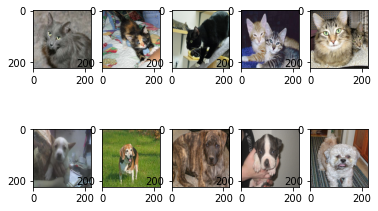

predictions on row 1: 
 [[9.94e-01 5.97e-03]
 [8.66e-01 1.34e-01]
 [7.86e-01 2.14e-01]
 [1.00e+00 4.83e-04]
 [1.00e+00 2.55e-04]]
predictions on row 2: 
 [[8.39e-01 1.61e-01]
 [3.35e-05 1.00e+00]
 [4.96e-01 5.04e-01]
 [4.82e-01 5.18e-01]
 [4.19e-02 9.58e-01]]


In [ ]:
"""
try predictions
"""

import numpy as np

from PIL import Image

cat_list = glob.glob(os.path.join(TEST_CAT_DIR, '*.jpg'))
dog_list = glob.glob(os.path.join(TEST_DOG_DIR, '*.jpg'))

cats = cat_list[:5]
dogs = dog_list[:5]

cats = [Image.open(cat).resize((224, 224), Image.ANTIALIAS) for cat in cats]
dogs = [Image.open(dog).resize((224, 224), Image.ANTIALIAS) for dog in dogs]

_cats = [np.asarray(cat) / 255.0 for cat in cats]
_dogs = [np.asarray(dog) / 255.0 for dog in dogs]

p_cats = myVGG.predict(np.array(_cats))
p_dogs = myVGG.predict(np.array(_dogs))

rows = 2
columns = 5

fig = plt.figure()

for idx, cat in enumerate(cats):
  fig.add_subplot(rows, columns, idx+1)
  plt.imshow(cat)

for idx, dog in enumerate(dogs):
  fig.add_subplot(rows, columns, idx+1+columns)
  plt.imshow(dog)

plt.show(fig)

print("predictions on row 1: \n", np.array_str(p_cats, precision=2))
print("predictions on row 2: \n", np.array_str(p_dogs, precision=2))